# Building a CV model from scratch

In [816]:
from ModularCirc.Models.OdeModel import OdeModel 
from ModularCirc.Components import Rlc_component, Valve_non_ideal, Valve_simple_bernoulli, Valve_maynard, HC_mixed_elastance

In [817]:
class NaghaviModel(OdeModel):
    def __init__(self, time_setup_dict, parobj, suppress_printing:bool=False) -> None:
        super().__init__(time_setup_dict)
        self.name = 'NaghaviModel'
        
        if not suppress_printing: print(parobj)
                
        # Defining the aorta object
        self.commponents['ao'] = Rlc_component( name='Aorta',
                                time_object=self.time_object, 
                                r     = parobj['ao']['r'],
                                c     = parobj['ao']['c'], 
                                l     = parobj['ao']['l'],
                                v_ref = parobj['ao']['v_ref'],
                                v     = parobj['ao']['v'],
                                  )
        self.set_v_sv('ao')
        
        # Defining the arterial system object
        self.commponents['art'] = Rlc_component(name='Arteries',
                                time_object=self.time_object,
                                r     = parobj['art']['r'],
                                c     = parobj['art']['c'], 
                                l     = parobj['art']['l'],
                                v_ref = parobj['art']['v_ref'],
                                v     = parobj['art']['v'],
                                )
        self.set_v_sv('art')
        
        # Defining the venous system object
        self.commponents['ven'] = Rlc_component(name='VenaCava',
                                time_object=self.time_object,
                                r     = parobj['ven']['r'],
                                c     = parobj['ven']['c'], 
                                l     = parobj['ven']['l'],
                                v_ref = parobj['ven']['v_ref'],
                                v     = parobj['ven']['v'],
                                )
        self.set_v_sv('ven')
                
        # Defining the aortic valve object
        self.commponents['av']  = Valve_non_ideal(name='AorticValve',
                                     time_object=self.time_object,
                                     r=parobj['av']['r'],
                                     max_func=parobj['av']['max_func']
                                     )
        
        # Defining the mitral valve object
        self.commponents['mv'] = Valve_non_ideal(name='MitralValve',
                                    time_object=self.time_object,
                                    r=parobj['mv']['r'],
                                    max_func=parobj['mv']['max_func']
                                    )
        
        # Defining the left atrium law
        self.commponents['la'] = HC_mixed_elastance(name='LeftAtrium',
                                        time_object=self.time_object,
                                        E_pas=parobj['la']['E_pas'],
                                        E_act=parobj['la']['E_act'],
                                        v_ref=parobj['la']['v_ref'],
                                        k_pas=parobj['la']['k_pas'],
                                        v    =parobj['la']['v'],
                                        af   =parobj['la']['activation_function'],
                                        t_tr =parobj['la']['t_tr'], 
                                        t_max=parobj['la']['t_max'],
                                        tau  =parobj['la']['tau'], 
                                        delay=parobj['la']['delay']
                                        )
        self._state_variable_dict['v_la'] = self.commponents['la']._V
        self._state_variable_dict['v_la'].set_name('v_la')
        self.all_sv_data['v_la'] = self.commponents['la'].V
        self.commponents['la']._V._u = self.all_sv_data['v_la']
        
        # Defining the left ventricle activation function
        self.commponents['lv'] = HC_mixed_elastance(name='LeftVentricle', 
                                        time_object=self.time_object,
                                        E_pas=parobj['lv']['E_pas'],
                                        E_act=parobj['lv']['E_act'],
                                        k_pas=parobj['lv']['k_pas'],
                                        v_ref=parobj['lv']['v_ref'],
                                        v    =parobj['lv']['v'],
                                        af   =parobj['lv']['activation_function'],
                                        t_tr =parobj['la']['t_tr'], 
                                        t_max=parobj['la']['t_max'],
                                        tau  =parobj['la']['tau'],
                                        delay=parobj['lv']['delay']
                                        )
        self._state_variable_dict['v_lv'] = self.commponents['lv']._V
        self._state_variable_dict['v_lv'].set_name('v_lv')
        self.all_sv_data['v_lv'] = self.commponents['lv'].V
        self.commponents['lv']._V._u = self.all_sv_data['v_lv']
        
        for component in self.commponents.values():
            component.setup()
        
        # connect the left ventricle class to the aortic valve
        self.connect_modules(self.commponents['lv'],  
                             self.commponents['av'],  
                             plabel='p_lv',   
                             qlabel='q_av',
                             )
        # connect the aortic valve to the aorta
        self.connect_modules(self.commponents['av'],  
                             self.commponents['ao'],  
                             plabel='p_ao',   
                             qlabel='q_av')
        # connect the aorta to the arteries
        self.connect_modules(self.commponents['ao'],  
                             self.commponents['art'], 
                             plabel= 'p_art', 
                             qlabel= 'q_ao')
        # connect the arteries to the veins
        self.connect_modules(self.commponents['art'], 
                             self.commponents['ven'], 
                             plabel= 'p_ven', 
                             qlabel= 'q_art')
        # connect the veins to the left atrium
        self.connect_modules(self.commponents['ven'], 
                             self.commponents['la'],  
                             plabel= 'p_la',  
                             qlabel='q_ven',
                             )
        # connect the left atrium to the mitral valve
        self.connect_modules(self.commponents['la'],  
                             self.commponents['mv'],  
                             plabel= 'p_la', 
                             qlabel='q_mv')
        # connect the mitral valve to the left ventricle
        self.connect_modules(self.commponents['mv'],  
                             self.commponents['lv'],  
                             plabel='p_lv',  
                             qlabel='q_mv',
                             )
        
        for component in self.commponents.values():
            component.setup()

In [818]:
from ModularCirc.Models.ParametersObject import ParametersObject
from ModularCirc.HelperRoutines import activation_function_2, activation_function_1, relu_max
import pandas as pd

In [819]:
class PO(ParametersObject):
    def __init__(self, name='Naghavi Model') -> None:
        super().__init__(name=name)
        components = ['ao', 'art', 'ven', 'av', 'mv', 'la', 'lv']
        self.components = {key : None for key in components}
        for key in ['ao', 'art', 'ven']:
            self.components[key] = pd.Series(index=['r', 'c', 'l', 'v_ref', 'v', 'p'], dtype=object)
        for key in ['av', 'mv']:
            self.components[key] = pd.Series(index=['r', 'max_func'], dtype=object)
        for key in ['la', 'lv']:
            self.components[key] = pd.Series(index=['E_pas', 
                                                    'E_act', 
                                                    'v_ref', 
                                                    'k_pas',
                                                    'activation_function', 
                                                    't_tr', 
                                                    't_max',
                                                    'tau', 
                                                    'delay',
                                                    'v',
                                                    'p',
                                                    'activation_func'], dtype=object)
                        
        self.set_rlc_comp(key='ao',  r=240.,  c=0.3,  l=0.0, v_ref=100.,  v=0.025*5200.0, p=None)
        self.set_rlc_comp(key='art', r=1125., c=3.0,  l=0.0, v_ref=900.,  v=0.21 *5200.0, p=None)
        self.set_rlc_comp(key='ven', r=9.0 ,  c=133.3,l=0.0, v_ref=2800., v=0.727*5200.0, p=None)
        
        self.set_valve_comp(key='av', r=6.  , max_func=relu_max)
        self.set_valve_comp(key='mv', r=4.1,  max_func=relu_max)     
        
        
        # original
        self.set_chamber_comp('la', E_pas=0.44, E_act=0.45, v_ref=10., k_pas=0.05, # 0.05
                              activation_function=activation_function_1,
                              t_tr=225., t_max=150., tau=25., delay=100., v=0.018*5200.0, p=None)

        self.set_chamber_comp('lv', E_pas=1.0, E_act=3.0, v_ref=10., k_pas=0.027, # 0.027
                              activation_function=activation_function_1,
                              t_tr=420., t_max=280., tau=25., delay=None, v=0.02*5200.0, p=None)
    
    def set_rc_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['ao','art', 'ven'], **kwargs)
        
    def set_rlc_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['ao','art', 'ven'], **kwargs)
        
    def set_valve_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['av', 'mv'], **kwargs)
            
    
    def set_chamber_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['lv', 'la'], **kwargs)
         
    def set_activation_function(self, key:str, activation_func=activation_function_2):
        self._set_comp(key=key, set=['lv', 'la'], activation_func=activation_function_2)

In [820]:
po = PO()

In [821]:
TIME_SETUP_DICT = {
        'name'       :  'TimeTest', # the name asssociated with the temporal discretization (not super important.. names internat variable)
        'ncycles'    :  60,         # the maximum number of cycles for which we run the simulation
        'tcycle'     :  1000.,      # the duration of a heart beat (here in ms)
        'dt'         :  1.0,        # the duration of a discrete time step
        'export_min' :  1           # number of time steps for which we export the simulation (can also be used as a way to impose a minimum number of pulses)
    }

In [822]:
model = NaghaviModel(time_setup_dict=TIME_SETUP_DICT, parobj=po, suppress_printing=True) 

In [823]:
from ModularCirc.Solver import Solver

In [824]:
solver = Solver(model)

In [825]:
solver.setup(suppress_output=True)

In [826]:
solver.solve()

In [827]:
from ModularCirc.Analysis.BaseAnalysis import BaseAnalysis
import matplotlib.pyplot as plt

In [828]:
ba = BaseAnalysis(model=model)

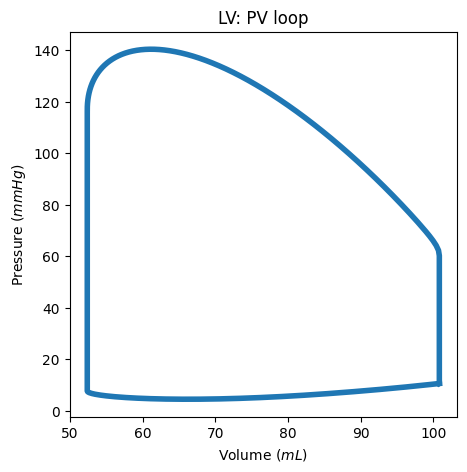

In [829]:
ba.plot_p_v_loop('lv')
plt.show()

In [ ]:
ba.plot_p_v_loop('la')
plt.show()

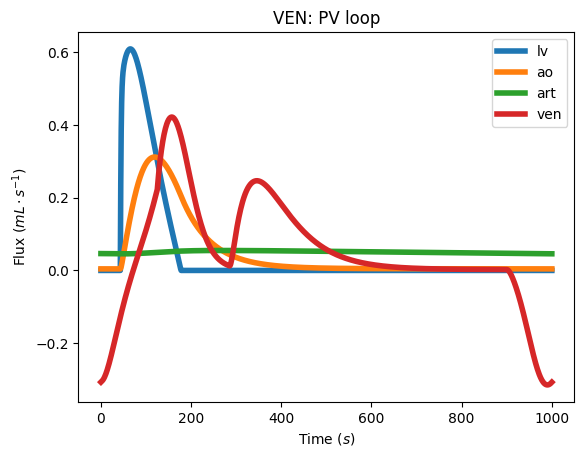

In [830]:
fig, ax = plt.subplots()
ba.plot_t_q_out('lv', ax)
ba.plot_t_q_out('ao', ax)
ba.plot_t_q_out('art', ax)
ba.plot_t_q_out('ven', ax)
ax.legend()
plt.show()

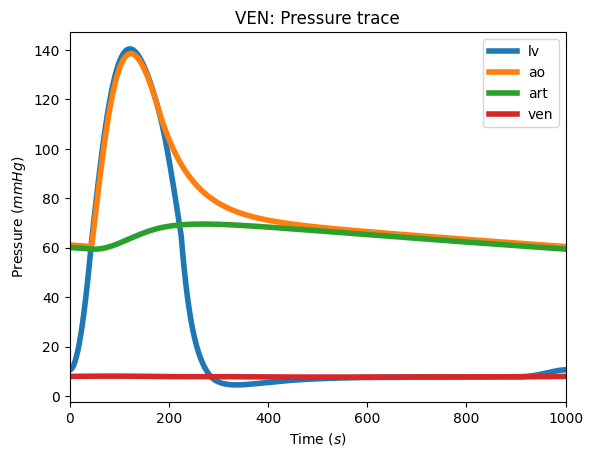

In [831]:
fig, ax = plt.subplots()
ba.plot_t_p('lv', ax)
ba.plot_t_p('ao', ax)
ba.plot_t_p('art', ax)
ba.plot_t_p('ven', ax)
ax.legend()
plt.show()

In [832]:
class NewModel(OdeModel):
    def __init__(self, time_setup_dict, parobj, suppress_printing:bool=False) -> None:
        super().__init__(time_setup_dict)
        self.name = 'NaghaviModel'
        
        if not suppress_printing: print(parobj)
                
        # Defining the aorta object
        self.commponents['ao'] = Rlc_component( name='Aorta',
                                time_object=self.time_object, 
                                r     = parobj['ao']['r'],
                                c     = parobj['ao']['c'], 
                                l     = parobj['ao']['l'],
                                v_ref = parobj['ao']['v_ref'],
                                v     = parobj['ao']['v'],
                                  )
        self.set_v_sv('ao')
        
        # Defining the arterial system object
        self.commponents['art'] = Rlc_component(name='Arteries',
                                time_object=self.time_object,
                                r     = parobj['art']['r'],
                                c     = parobj['art']['c'], 
                                l     = parobj['art']['l'],
                                v_ref = parobj['art']['v_ref'],
                                v     = parobj['art']['v'],
                                )
        self.set_v_sv('art')
        
        # Defining the venous system object
        self.commponents['ven'] = Rlc_component(name='VenaCava',
                                time_object=self.time_object,
                                r     = parobj['ven']['r'],
                                c     = parobj['ven']['c'], 
                                l     = parobj['ven']['l'],
                                v_ref = parobj['ven']['v_ref'],
                                v     = parobj['ven']['v'],
                                )
        self.set_v_sv('ven')
                
        # Defining the aortic valve object
        self.commponents['av']  = Valve_maynard(name='AorticValve',
                                     time_object=self.time_object,
                                     Kc = parobj['av']['Kc'],
                                     Ko = parobj['av']['Ko'],
                                     CQ = parobj['av']['CQ'],
                                     )
        self.set_phi_sv('av')
        
        # Defining the mitral valve object
        self.commponents['mv'] = Valve_maynard(name='MitralValve',
                                    time_object=self.time_object,
                                    Kc = parobj['mv']['Kc'],
                                    Ko = parobj['mv']['Ko'],
                                    CQ = parobj['mv']['CQ'],
                                    )
        self.set_phi_sv('mv')
        
        # Defining the left atrium law
        self.commponents['la'] = HC_mixed_elastance(name='LeftAtrium',
                                        time_object=self.time_object,
                                        E_pas=parobj['la']['E_pas'],
                                        E_act=parobj['la']['E_act'],
                                        v_ref=parobj['la']['v_ref'],
                                        k_pas=parobj['la']['k_pas'],
                                        v    =parobj['la']['v'],
                                        af   =parobj['la']['activation_function'],
                                        t_tr =parobj['la']['t_tr'], 
                                        t_max=parobj['la']['t_max'],
                                        tau  =parobj['la']['tau'], 
                                        delay=parobj['la']['delay']
                                        )
        self._state_variable_dict['v_la'] = self.commponents['la']._V
        self._state_variable_dict['v_la'].set_name('v_la')
        self.all_sv_data['v_la'] = self.commponents['la'].V
        self.commponents['la']._V._u = self.all_sv_data['v_la']
        # self.set_v_sv('la')
        
        # Defining the left ventricle activation function
        self.commponents['lv'] = HC_mixed_elastance(name='LeftVentricle', 
                                        time_object=self.time_object,
                                        E_pas=parobj['lv']['E_pas'],
                                        E_act=parobj['lv']['E_act'],
                                        k_pas=parobj['lv']['k_pas'],
                                        v_ref=parobj['lv']['v_ref'],
                                        v    =parobj['lv']['v'],
                                        af   =parobj['lv']['activation_function'],
                                        t_tr =parobj['la']['t_tr'], 
                                        t_max=parobj['la']['t_max'],
                                        tau  =parobj['la']['tau'],
                                        delay=parobj['lv']['delay']
                                        )
        self._state_variable_dict['v_lv'] = self.commponents['lv']._V
        self._state_variable_dict['v_lv'].set_name('v_lv')
        self.all_sv_data['v_lv'] = self.commponents['lv'].V
        self.commponents['lv']._V._u = self.all_sv_data['v_lv']
        # self.set_v_sv('lv')
        
        for component in self.commponents.values():
            component.setup()
        
        # connect the left ventricle class to the aortic valve
        self.connect_modules(self.commponents['lv'],  
                             self.commponents['av'],  
                             plabel='p_lv',   
                             qlabel='q_av',
                             )
        # connect the aortic valve to the aorta
        self.connect_modules(self.commponents['av'],  
                             self.commponents['ao'],  
                             plabel='p_ao',   
                             qlabel='q_av')
        # connect the aorta to the arteries
        self.connect_modules(self.commponents['ao'],  
                             self.commponents['art'], 
                             plabel= 'p_art', 
                             qlabel= 'q_ao')
        # connect the arteries to the veins
        self.connect_modules(self.commponents['art'], 
                             self.commponents['ven'], 
                             plabel= 'p_ven', 
                             qlabel= 'q_art')
        # connect the veins to the left atrium
        self.connect_modules(self.commponents['ven'], 
                             self.commponents['la'],  
                             plabel= 'p_la',  
                             qlabel='q_ven',
                             )
        # connect the left atrium to the mitral valve
        self.connect_modules(self.commponents['la'],  
                             self.commponents['mv'],  
                             plabel= 'p_la', 
                             qlabel='q_mv')
        # connect the mitral valve to the left ventricle
        self.connect_modules(self.commponents['mv'],  
                             self.commponents['lv'],  
                             plabel='p_lv',  
                             qlabel='q_mv',
                             )
        
        for component in self.commponents.values():
            component.setup()
    
    def set_phi_sv(self, comp_key:str) -> None:
        phi_key = 'phi_' + comp_key
        self._state_variable_dict[phi_key] = self.commponents[comp_key]._PHI
        self._state_variable_dict[phi_key].set_name(phi_key)
        self.all_sv_data[phi_key] = self.commponents[comp_key].PHI

In [833]:
class NewPO(ParametersObject):
    def __init__(self, name='Naghavi Model') -> None:
        super().__init__(name=name)
        components = ['ao', 'art', 'ven', 'av', 'mv', 'la', 'lv']
        self.components = {key : None for key in components}
        for key in ['ao', 'art', 'ven']:
            self.components[key] = pd.Series(index=['r', 'c', 'l', 'v_ref', 'v', 'p'], dtype=object)
        for key in ['av', 'mv']:
            self.components[key] = pd.Series(index=['Kc', 'Ko', 'CQ', 'L', 'R'], dtype=object)
        for key in ['la', 'lv']:
            self.components[key] = pd.Series(index=['E_pas', 
                                                    'E_act', 
                                                    'v_ref', 
                                                    'k_pas',
                                                    'activation_function', 
                                                    't_tr', 
                                                    't_max',
                                                    'tau', 
                                                    'delay',
                                                    'v',
                                                    'p',
                                                    'activation_func'], dtype=object)
                        
        self.set_rlc_comp(key='ao',  r=240.,  c=0.3,  l=0.0, v_ref=100.,  v=0.025*5200.0, p=None)
        self.set_rlc_comp(key='art', r=1125., c=3.0,  l=0.0, v_ref=900.,  v=0.21 *5200.0, p=None)
        self.set_rlc_comp(key='ven', r=9.0 ,  c=133.3,l=0.0, v_ref=2800., v=0.727*5200.0, p=None)
        
        dyn = 1333.22 
        # val = 1.0e5/ dyn / 1e3 #  0.05/dyn * 1000. # 1e2 
        val = 2e3 / dyn
        self.set_valve_comp(key='av',Kc = val,
                                     Ko = val,
                                     CQ = 350. / 1e3,
                                     L = 0.0,
                                     R = 0.0,
                                     )
        # val = 1.0e5 / dyn / 1e3
        val = 2e3 / dyn
        self.set_valve_comp(key='mv',Kc = val,
                                     Ko = val,
                                     CQ = 400. /1e3,
                                     L = 0.0,
                                     R = 0.0
                                     )
        
        
        # original
        self.set_chamber_comp('la', E_pas=0.44, E_act=0.45, v_ref=10., k_pas=0.05, # 0.05
                              activation_function=activation_function_1,
                              t_tr=225., t_max=150., tau=25., delay=100., v=0.018*5200.0, p=None)

        self.set_chamber_comp('lv', E_pas=1.0, E_act=3.0, v_ref=10., k_pas=0.027, # 0.027
                              activation_function=activation_function_1,
                              t_tr=420., t_max=280., tau=25., delay=None, v=0.02*5200.0, p=None)
    
    def set_rc_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['ao','art', 'ven'], **kwargs)
        
    def set_rlc_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['ao','art', 'ven'], **kwargs)
        
    def set_valve_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['av', 'mv'], **kwargs)
            
    
    def set_chamber_comp(self, key:str, **kwargs):
        self._set_comp(key=key, set=['lv', 'la'], **kwargs)
         
    def set_activation_function(self, key:str, activation_func=activation_function_2):
        self._set_comp(key=key, set=['lv', 'la'], activation_func=activation_function_2)

In [834]:
new_po = NewPO()

In [835]:
new_model = NewModel(
    time_setup_dict=TIME_SETUP_DICT, 
    parobj=new_po, 
    suppress_printing=True
    )

In [836]:
new_solver = Solver(new_model)

In [837]:
new_solver.setup(
    suppress_output=True, 
    conv_cols=['p_lv', 'v_lv'],
    step_tol=1e-3,
    method='BDF',
    )

In [838]:
new_solver.solve()

In [839]:
new_solver.converged

True

In [840]:
solver.Nconv

6

In [841]:
new_ba = BaseAnalysis(model=new_model)

<Axes: title={'center': 'LV: PV loop'}, xlabel='Volume ($mL$)', ylabel='Pressure ($mmHg$)'>

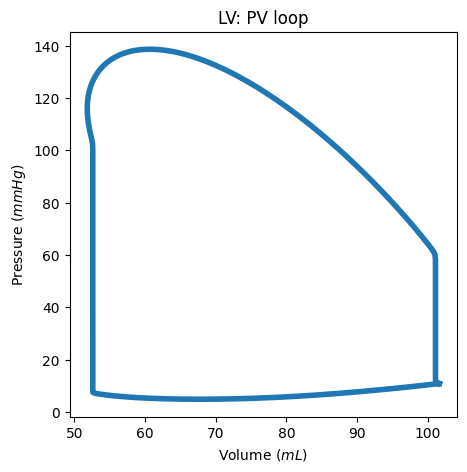

In [842]:
new_ba.plot_p_v_loop('lv')

<Axes: title={'center': 'LA: PV loop'}, xlabel='Volume ($mL$)', ylabel='Pressure ($mmHg$)'>

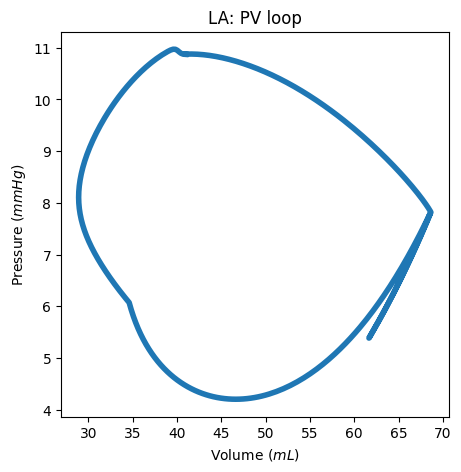

In [843]:
new_ba.plot_p_v_loop('la')

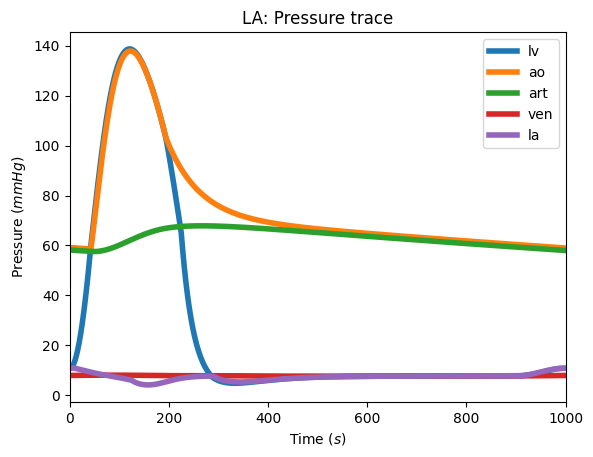

In [844]:
fig, ax = plt.subplots()
new_ba.plot_t_p('lv', ax)
new_ba.plot_t_p('ao', ax)
new_ba.plot_t_p('art', ax)
new_ba.plot_t_p('ven', ax)
new_ba.plot_t_p('la', ax)
ax.legend()
plt.show()

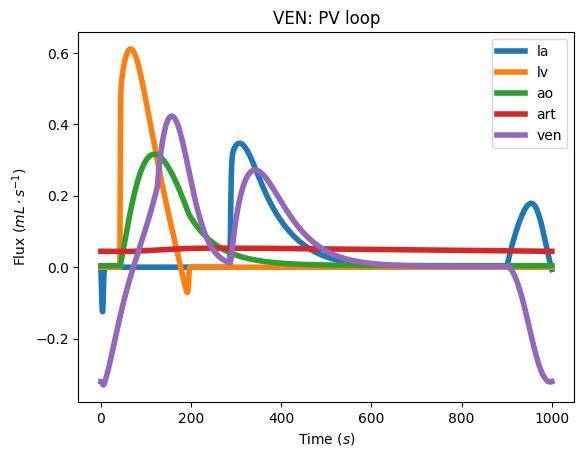

In [845]:
fig, ax = plt.subplots()
new_ba.plot_t_q_out('la', ax)
new_ba.plot_t_q_out('lv', ax)
new_ba.plot_t_q_out('ao', ax)
new_ba.plot_t_q_out('art', ax)
new_ba.plot_t_q_out('ven', ax)
ax.legend()
plt.show()

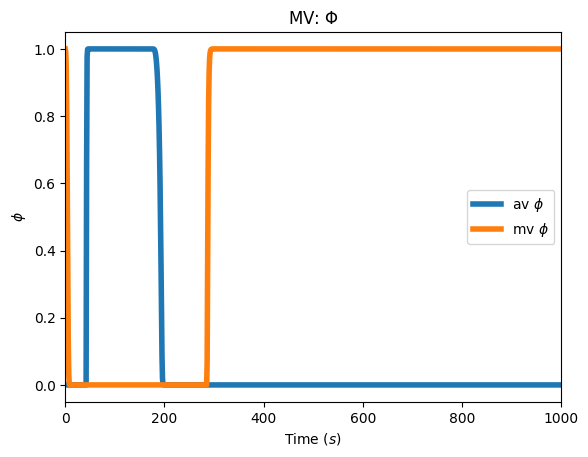

In [846]:
fig, ax = plt.subplots()
new_ba.plot_valve_opening('av', ax)
new_ba.plot_valve_opening('mv', ax)
plt.show()